In [1]:
import os
import matplotlib.pylab as plt
import numpy as np
from Hang.utils_u_groupnorm_pytorchLightning import *
from utils import *
import nibabel as nib
from scipy.stats import ttest_ind
from statsmodels.graphics.agreement import mean_diff_plot
import pandas as pd

np.random.seed(0)
random.seed(5)
torch.manual_seed(0)

/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/Jeremy/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
statistics = {}

In [3]:
dataName = ["res256", "res256Lesion", "res256snr200Avg", "res256snr100Avg", "res256snr50Avg", "res256snr25Avg", 
            "res256snr200LesionAvg", "res256snr100LesionAvg", "res256snr50LesionAvg", "res256snr25LesionAvg", 
            "resRepro", "simData", "simDataLesion"]

In [20]:
TYPE = '32'
SR = True

In [21]:
dataName = dataName if TYPE == '6' else dataName[:2]
dataName = dataName if SR else dataName[:2]

In [22]:
mlpData = np.load("mlpData.npy", allow_pickle=True) if TYPE == '6' else np.load("mlpData_32_te.npy", allow_pickle=True)
mlpData = mlpData if SR else np.load("mlpData_no_sr.npy", allow_pickle=True)
unetData = np.load("unetData.npy", allow_pickle=True) if TYPE == '6' else np.load("unetData_32_te.npy", allow_pickle=True)
unetData = unetData if SR else np.load("unetData_no_sr.npy", allow_pickle=True)

In [23]:
MLP = "ann_gpu3_256_32"
UNET = "0_weight"

numbers = ["0001","0017","0018","0038","0040","0042","0046","0087","0090","0108","0116","0131","0178","0190",
           "0227","0248","0267","0282","0285","0398","0448","0466","0504","0514","0535","0564","0598","0606",
           "0607","0618","0620","0623","0642","0646","0655","0668","0675","0681","0719","0761","0762","0783",
           "0786","0868","0877","0887","0895","0902","0931","0979","1007","1013","1029","1033","1068","1142",
           "1143","1163","1190","1260","1275","1347","1383","1389","1416","1435","1441","1447","1451","1514",
           "1520","1602","1611","1621","1680","1684","1686","1710","1720","1739","1743","1749","1753","1760",
           "1795","1805","1845","1858","1876","1889","1892","1898","1899","1918","1924","1932","1952","1961",
           "1972","1987","2003","2007","2016","2020","2022","2030","2045","2047","2049","2053","2055","2074",
           "2077","2080","2091","2094","2103","2115","2128","2142","2144","2146","2152","2156","2158","2160",
           "2161","2179","2180","2181","2183","2186","2188","2212","2221","2231","2234","2245"]
numbers = numbers[75:]

good_nums = [i for i in numbers if i not in ['1260', '1275', '1749', '1760', '1889', '2091', '2146', '2234']]

In [24]:
for idx in range(len(dataName)):
    name = dataName[idx]
    statistics[name] = {}
    statistics[name]['mlp'] = mlpData[idx]
    statistics[name]['unet'] = unetData[idx]

In [25]:
unet_test_stats = statistics["res256"]["unet"][0]
mlp_test_stats = statistics["res256"]["mlp"][0]
print(np.mean(unet_test_stats), np.std(unet_test_stats))
print(np.mean(mlp_test_stats), np.std(mlp_test_stats))

1.2638133009908636 0.1940409834314364
2.2533090196077223 0.13585048740776992


### Exemplary Case

In [8]:
masks = []

for number in numbers:
    file_root = "../" + number + "/"
    masks.append(file_root + "lesion.nii.gz")

mask_array = []

for i in range(len(masks)):
    mask_array.append(nib.load(masks[i]).get_fdata()) 

In [9]:
num_lesions = [(numbers[i], np.max(mask_array[i])) for i in range(len(mask_array))]

In [10]:
sorted_by_lesions = sorted(num_lesions, key=lambda tup: tup[1])

In [11]:
case = '2183'
FLAIR_PATH = {"2183": "2183_20190703_173052_T2FLAIR_to_FASTT2.nii.gz", 
              "2016": "2016_20191014_175119_T2FLAIR_to_FASTT2.nii.gz",
              "1952": "1952_20190521_140951_T2FLAIR_to_FASTT2.nii.gz",
              "2161": "2161_20190517_175848_T2FLAIR_to_FASTT2.nii.gz",
              "2103": "2103_20190224_153730_T2FLAIR_to_FASTT2.nii.gz",
              "2074": "2074_20190115_154722_T2FLAIR_to_FASTT2.nii.gz", 
              "2047": "2047_20190511_141213_T2FLAIR_to_FASTT2.nii.gz", 
              "1898": "1898_20181215_155013_T2FLAIR_to_FASTT2.nii.gz", 
              "2152": "2152_20190508_132919_T2FLAIR_to_FASTT2.nii.gz", 
              "2221": "2221_20190908_102028_T2FLAIR_to_FASTT2.nii.gz", 
              "2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u = nib.load(f'results/0_weight_new/MWF/{case}_pred_UNET_256real.nii.gz').get_fdata()
err_u = nib.load(f'results/0_weight_new/MWF/{case}_err_UNET_256real.nii.gz').get_fdata()

image_a = nib.load(f"results/ann_gpu3_256_32/MWF/{case}_pred_MLP_256real.nii.gz").get_fdata()
err_a = nib.load(f"results/ann_gpu3_256_32/MWF/{case}_err_MLP_256real.nii.gz").get_fdata()

label = nib.load(f"results/0_weight_new/MWF/{case}_label_UNET_256real.nii.gz").get_fdata()
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/tightmask.nii.gz").get_fdata()

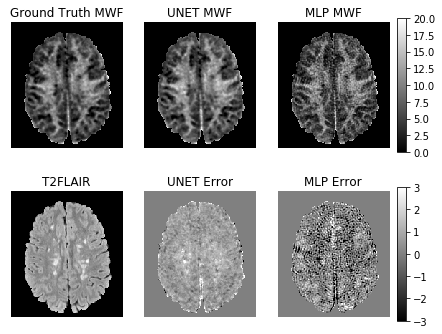

In [12]:
fig, axs = plt.subplots(2,3)
SLICE = 20
arr = [[label, image_u, image_a], [FLAIR, err_u, err_a]]
clips = [[[0,20], [0,20], [0,20]], [[], [-3,3], [-3,3]]]
titles = [["Ground Truth MWF", "UNET MWF", "MLP MWF"], ["T2FLAIR", "UNET Error", "MLP Error"]]
pos = [[1.02,0.723,0.02,0.465],[1.02,0.137,0.02,0.465]]
fig.subplots_adjust(right=1,top=1.2)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        sliced = (slice(50,-50),slice(40,-40),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 2):
            cb = fig.add_axes(pos[i])
            fig.colorbar(im, cax=cb)

### Graph 1

In [13]:
wholeBrainErr = pd.DataFrame()

In [14]:
wholeBrainErr['id'] = numbers

In [15]:
wholeBrainErr["unet_myelin"] = statistics["res256"]['unet'][0] 
wholeBrainErr["unet_iewf"] = statistics["res256"]['unet'][1] 
wholeBrainErr["unet_csff"] = statistics["res256"]['unet'][2] 
wholeBrainErr["unet_myelinT2"] = statistics["res256"]['unet'][3] 
wholeBrainErr["unet_iewfT2"] = statistics["res256"]['unet'][4] 
wholeBrainErr["unet_csffT2"] = statistics["res256"]['unet'][5] 

wholeBrainErr["mlp_myelin"] = statistics["res256"]['mlp'][0] 
wholeBrainErr["mlp_iewf"] = statistics["res256"]['mlp'][1] 
wholeBrainErr["mlp_csff"] = statistics["res256"]['mlp'][2] 
wholeBrainErr["mlp_myelinT2"] = statistics["res256"]['mlp'][3] 
wholeBrainErr["mlp_iewfT2"] = statistics["res256"]['mlp'][4] 
wholeBrainErr["mlp_csffT2"] = statistics["res256"]['mlp'][5] 

In [16]:
lesionErr = pd.DataFrame()

In [17]:
lesionErr['id'] = good_nums

In [18]:
lesionErr["unet_myelin"] = statistics["res256Lesion"]['unet'][0] 
lesionErr["unet_iewf"] = statistics["res256Lesion"]['unet'][1] 
lesionErr["unet_csff"] = statistics["res256Lesion"]['unet'][2] 
lesionErr["unet_myelinT2"] = statistics["res256Lesion"]['unet'][3] 
lesionErr["unet_iewfT2"] = statistics["res256Lesion"]['unet'][4] 
lesionErr["unet_csffT2"] = statistics["res256Lesion"]['unet'][5] 

lesionErr["mlp_myelin"] = statistics["res256Lesion"]['mlp'][0] 
lesionErr["mlp_iewf"] = statistics["res256Lesion"]['mlp'][1] 
lesionErr["mlp_csff"] = statistics["res256Lesion"]['mlp'][2] 
lesionErr["mlp_myelinT2"] = statistics["res256Lesion"]['mlp'][3] 
lesionErr["mlp_iewfT2"] = statistics["res256Lesion"]['mlp'][4] 
lesionErr["mlp_csffT2"] = statistics["res256Lesion"]['mlp'][5] 

In [19]:
np.mean(statistics["res256Lesion"]['mlp'][0])

1.2329819524632541

In [21]:
from scipy.stats import ranksums

In [25]:
print(ranksums(statistics["res256"]['unet'][0], statistics["res256"]['mlp'][0]))
print(ranksums(statistics["res256Lesion"]['unet'][0], statistics["res256Lesion"]['mlp'][0]))

RanksumsResult(statistic=-8.2385214743657, pvalue=1.7435177290074493e-16)
RanksumsResult(statistic=-6.622097395315436, pvalue=3.5413758220123186e-11)


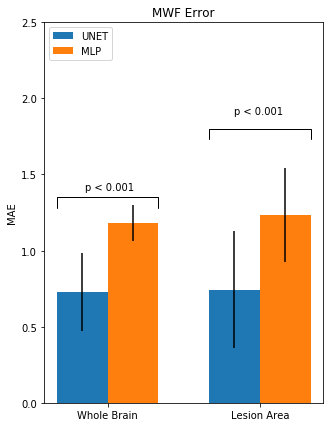

In [59]:
WHOLE_BRAIN_UNET = -0.1
WHOLE_BRAIN_MLP = -0.05
LESION_UNET = 0.05
LESION_MLP = 0.1
x = [WHOLE_BRAIN_UNET, LESION_UNET]
arrowprops = {"arrowstyle": "-", "shrinkA": 20, "shrinkB": 20, "connectionstyle": "bar"}
plt.figure(figsize=(5,7))
plt.bar(x, [np.mean(statistics["res256"]['unet'][0]), np.mean(statistics["res256Lesion"]['unet'][0])], 
        width = 0.05, yerr = [np.std(statistics["res256"]['unet'][0]), 
                              np.std(statistics["res256Lesion"]['unet'][0])], label="UNET")
x = [WHOLE_BRAIN_MLP, LESION_MLP]
plt.bar(x, [np.mean(statistics["res256"]['mlp'][0]), np.mean(statistics["res256Lesion"]['mlp'][0])], 
        width = 0.05, yerr = [np.std(statistics["res256"]['mlp'][0]),
                              np.std(statistics["res256Lesion"]['mlp'][0])], label="MLP")
plt.xticks([-0.075, 0.075], ["Whole Brain", "Lesion Area"])
plt.annotate("p < 0.001", xy=(-0.097,1.4))
plt.annotate("", xy=(-0.125,1.15),xytext=(-0.025,1.15), arrowprops=arrowprops)
plt.annotate("p < 0.001", xy=(0.05,1.9))
plt.annotate("", xy=(0.025,1.6),xytext=(0.125,1.6), arrowprops=arrowprops)
plt.ylabel("MAE")
plt.title("MWF Error")
plt.legend(loc = "upper left")
plt.ylim(0,2.5)
plt.show()

### Graph 3

In [44]:
rois = {
    "wm_frontal_lobe": [3201, 4201],
    "wm_parietal_lobe" : [3206, 4206],
    "wm_temporal_lobe" : [3205, 4205],
    "wm_occipital_lobe" : [3204, 4204],
    "thalamus" : [10, 49],
    "caudate" : [11, 50],
    "putamen" : [12, 51],
    "pallidum" : [13, 52]
}

keys = rois.keys()

In [61]:
def getROIMeans(method):
    numbers = [['184051','184052'],['111720','111721'],['151025','151026'],['113307','113308'],['171732','154655'],
               ['163834','163835'],['125545','125546'],['175630','175631'],['101850','101851'],['093923','093924']]
    values = []
    for number_pair in numbers:
        CASE_A = number_pair[0]
        CASE_B = number_pair[1]
        A_PATH = f"../{CASE_A}"
        B_PATH = f"../{CASE_B}"
        image_a = None
        image_b = None
        if (method == "UNET"):
            image_a = nib.load(f"results/0_weight_new/MWF/{CASE_A}_pred_UNET_repro.nii.gz").get_fdata()
            image_b = nib.load(f"results/0_weight_new/MWF/{CASE_B}_pred_UNET_repro.nii.gz").get_fdata()
        elif (method == "NLLS"):
            image_a = nib.load(f"{A_PATH}/MWF.nii.gz").get_fdata()
            image_b = nib.load(f"{B_PATH}/MWF.nii.gz").get_fdata()
        elif (method == "MLP"):
            image_a = nib.load(f"results/ann_gpu3_256_32/MWF/{CASE_A}_pred_MLP_repro.nii.gz").get_fdata()
            image_b = nib.load(f"results/ann_gpu3_256_32/MWF/{CASE_B}_pred_MLP_repro.nii.gz").get_fdata()
        seg_a = nib.load(f"{A_PATH}/segmentation.nii.gz").get_fdata()
        seg_b = nib.load(f"{B_PATH}/segmentation.nii.gz").get_fdata()
        means = {}
        for key in keys:
            mwfs_a = []
            mwfs_b = []
            means[key] = {}
            for seg in rois[key]:
                mwfs_a += image_a[seg_a == seg].reshape(-1).tolist()
                mwfs_b += image_b[seg_b == seg].reshape(-1).tolist()
            mwfs_a = np.array(mwfs_a)
            mwfs_b = np.array(mwfs_b)
            means[key]["A"] = mwfs_a.mean()
            means[key]["B"] = mwfs_b.mean()
            means[key]["id"] = CASE_A + "-" + str(rois[key][0]) + "," + str(rois[key][1]) + "-" + key
        values.append(means)
    return values

In [62]:
values_u = getROIMeans("UNET")
values_m = getROIMeans("MLP")
values_n = getROIMeans("NLLS")

In [55]:
reproDataNLLS = pd.DataFrame()
reproDataUNET = pd.DataFrame()
reproDataMLP = pd.DataFrame()

In [66]:
reproDataNLLS

,id,scanv1,scanv2
0,"184051-3201,4201-wm_frontal_lobe",10.781975,11.072784
1,"184051-3206,4206-wm_parietal_lobe",9.480332,9.628179
2,"184051-3205,4205-wm_temporal_lobe",8.724325,8.729078
3,"184051-3204,4204-wm_occipital_lobe",8.367299,8.604857
4,"184051-10,49-thalamus",5.580222,5.688427
...,...,...,...
75,"093923-3204,4204-wm_occipital_lobe",7.020663,6.650145
76,"093923-10,49-thalamus",4.318012,3.886097
77,"093923-11,50-caudate",2.065641,1.678845
78,"093923-12,51-putamen",2.717535,2.883601


In [56]:
errsReproBrains = pd.DataFrame()

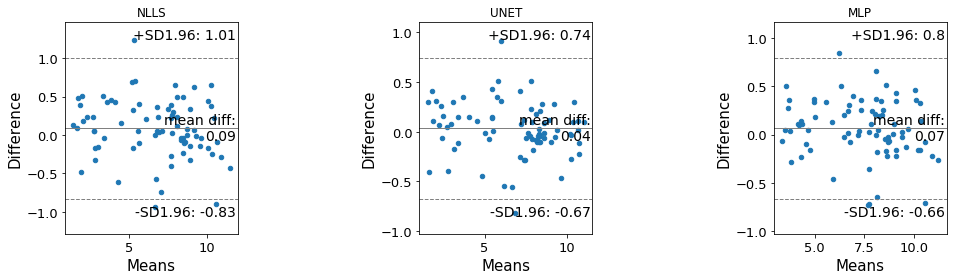

In [63]:
fig, axs = plt.subplots(1,3)
value_list = [values_n, values_u, values_m]
titles = ["NLLS", "UNET", "MLP"]
dfs = [reproDataNLLS, reproDataUNET, reproDataMLP]
for idx in range(len(axs)):
    ax = axs[idx]
    ax.set_title(titles[idx])
    values = value_list[idx]
    dataID = []
    data1 = []
    data2 = []
    for ROI in values:
        for key in keys:
            dataID.append(ROI[key]["id"])
            data1.append(ROI[key]["A"])
            data2.append(ROI[key]["B"])
    data1 = np.array(data1)
    data2 = np.array(data2)
    dfs[idx]["id"] = dataID
    dfs[idx]["scanv1"] = data1
    dfs[idx]["scanv2"] = data2
    mean_diff_plot(data1, data2, ax = ax, sd_limit=1.96,)
fig.subplots_adjust(right=2.2)
fig.show()

In [66]:
errsReproBrains['id'] = ['125545', '093924', '151026', '111721', '093923', '151025', '113308', '113307', '171732', 
                         '101851', '125546', '163835', '163834', '154655', '101850', '175630', '175631', '184052', 
                         '111720', '184051']

In [67]:
errsReproBrains["unet"] = statistics["resRepro"]['unet'][0]
errsReproBrains["mlp"] = statistics["resRepro"]['mlp'][0]

In [26]:
print(ranksums(statistics["resRepro"]['unet'][0], statistics["resRepro"]['mlp'][0]))

RanksumsResult(statistic=-3.8952128217633075, pvalue=9.811254512987531e-05)


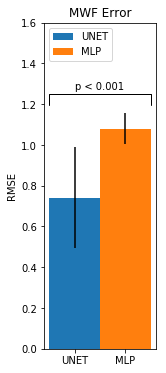

In [69]:
WHOLE_BRAIN_UNET = -0.025
WHOLE_BRAIN_MLP = 0.025
x = [WHOLE_BRAIN_UNET]
arrowprops = {"arrowstyle": "-", "shrinkA": 20, "shrinkB": 20, "connectionstyle": "bar"}
plt.figure(figsize=(2,6))
plt.bar(x, [np.mean(statistics["resRepro"]['unet'][0])], width = 0.05, 
        yerr = [np.std(statistics["resRepro"]['unet'][0])], label="UNET")
x = [WHOLE_BRAIN_MLP]
plt.bar(x, [np.mean(statistics["resRepro"]['mlp'][0])], 
        width = 0.05, yerr = [np.std(statistics["resRepro"]['mlp'][0])], label="MLP")
plt.xticks([WHOLE_BRAIN_UNET, WHOLE_BRAIN_MLP], ["UNET", "MLP"])
plt.annotate("p < 0.001", xy=(-0.025,1.27))
plt.annotate("", xy=(-0.05,1.1),xytext=(0.05,1.1), arrowprops=arrowprops)
plt.ylabel("RMSE")
plt.ylim(0,1.6)
plt.title("MWF Error")
plt.legend(loc = "upper left")
plt.show()

### Graph 2

In [70]:
unetBrainsWhole = []
mlpBrainsWhole = []
labelsWhole = []
unetBrainsLesion = []
mlpBrainsLesion = []
labelsLesion = []

for number in numbers:
    label = nib.load(f"results/0_weight_new/MWF/{number}_label_UNET_256real.nii.gz").get_fdata()
    unetPred = nib.load(f"results/0_weight_new/MWF/{number}_pred_UNET_256real.nii.gz").get_fdata()
    mlpPred = nib.load(f"results/ann_gpu3_256_32/MWF/{number}_pred_MLP_256real.nii.gz").get_fdata()
    mask = nib.load(f"../{number}/tightmask.nii.gz").get_fdata()
    lesion_mask = nib.load(f"../{number}/lesion.nii.gz").get_fdata()
    lesion_mask[lesion_mask >= 1] = 1
    lesion_mask[mask == 0] = 0
    unetBrainsWhole.append(unetPred[mask == 1].mean())
    mlpBrainsWhole.append(mlpPred[mask == 1].mean())
    labelsWhole.append(label[mask == 1].mean())
    if (lesion_mask.sum() > 0):
        unetBrainsLesion.append(unetPred[lesion_mask == 1].mean())
        mlpBrainsLesion.append(mlpPred[lesion_mask == 1].mean())
        labelsLesion.append(label[lesion_mask == 1].mean())

unetBrainsWhole = np.array(unetBrainsWhole)
mlpBrainsWhole = np.array(mlpBrainsWhole)
labelsWhole = np.array(labelsWhole)

unetBrainsLesion = np.array(unetBrainsLesion)
mlpBrainsLesion = np.array(mlpBrainsLesion)
labelsLesion = np.array(labelsLesion)

In [71]:
print(ttest_ind(labelsWhole, mlpBrainsWhole))
print(ttest_ind(labelsWhole, unetBrainsWhole))

Ttest_indResult(statistic=0.5942630532363189, pvalue=0.5534188653728118)
Ttest_indResult(statistic=1.0895808743279822, pvalue=0.2780107559568761)


In [72]:
print(ttest_ind(labelsLesion, mlpBrainsLesion))
print(ttest_ind(labelsLesion, unetBrainsLesion))

Ttest_indResult(statistic=1.1468215565570823, pvalue=0.2538994572545314)
Ttest_indResult(statistic=0.11405776442574253, pvalue=0.9093962145120801)


Text(0.5,1,'Lesion Area Mean MWF comparison \n per subject')

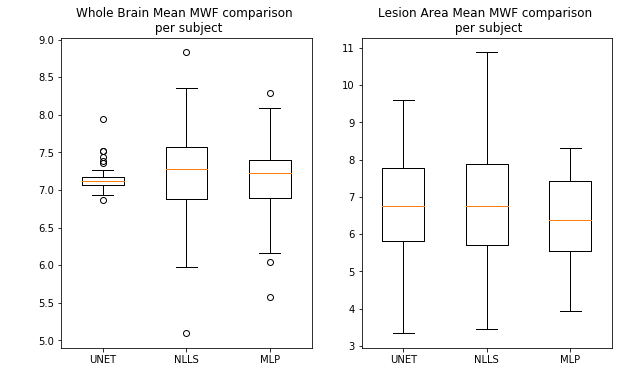

In [76]:
arrowprops = {"arrowstyle": "-", "shrinkA": 20, "shrinkB": 20, "connectionstyle": "bar"}
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(right=1.4, top=1.2)
axs[0].boxplot([unetBrainsWhole, labelsWhole, mlpBrainsWhole], labels=["UNET", "NLLS", "MLP"], widths=[0.5, 0.5, 0.5])
axs[0].set_title("Whole Brain Mean MWF comparison \n per subject")
axs[0].annotate("p < 0.001", xy=(2.24,11.1))
axs[0].annotate("", xy=(2,10.2),xytext=(3,10.2), arrowprops=arrowprops)
axs[1].boxplot([unetBrainsLesion, labelsLesion, mlpBrainsLesion], labels=["UNET", "NLLS", "MLP"], widths=[0.5, 0.5, 0.5])
axs[1].set_title("Lesion Area Mean MWF comparison \n per subject")


### Sim Case 2245

In [77]:
simulationErrorsWholeBrainSNR200 = pd.DataFrame()
simulationErrorsWholeBrainSNR100 = pd.DataFrame()
simulationErrorsWholeBrainSNR50 = pd.DataFrame()
simulationErrorsWholeBrainSNR25 = pd.DataFrame()

In [78]:
dfs = [simulationErrorsWholeBrainSNR200, simulationErrorsWholeBrainSNR100, 
       simulationErrorsWholeBrainSNR50, simulationErrorsWholeBrainSNR25]
# unet_errs = [statistics['res256snr200Avg']['unet'][0][0][0], statistics['res256snr100Avg']['unet'][0][0][0], 
#         statistics['res256snr50Avg']['unet'][0][0][0], statistics['res256snr25Avg']['unet'][0][0][0]]
# unet_std = [statistics['res256snr200Avg']['unet'][1][0][0], statistics['res256snr100Avg']['unet'][1][0][0], 
#         statistics['res256snr50Avg']['unet'][1][0][0], statistics['res256snr25Avg']['unet'][1][0][0]]

# mlp_errs = [statistics['res256snr200Avg']['mlp'][0][0][0], statistics['res256snr100Avg']['mlp'][0][0][0], 
#         statistics['res256snr50Avg']['mlp'][0][0][0], statistics['res256snr25Avg']['mlp'][0][0][0]]
# mlp_std = [statistics['res256snr200Avg']['mlp'][1][0][0], statistics['res256snr100Avg']['mlp'][1][0][0], 
#         statistics['res256snr50Avg']['mlp'][1][0][0], statistics['res256snr25Avg']['mlp'][1][0][0]]

In [79]:
for i in range(4):
    df = dfs[i]
    df['id'] = ['2245' for i in range(500)]
    df["unet"] = [k[0][0] for k in statistics["simData"]["unet"][i]]
    df["mlp"] = [k[0][0] for k in statistics["simData"]["mlp"][i]]

In [80]:
simulationErrorsLesionSNR200 = pd.DataFrame()
simulationErrorsLesionSNR100 = pd.DataFrame()
simulationErrorsLesionSNR50 = pd.DataFrame()
simulationErrorsLesionSNR25 = pd.DataFrame()

In [81]:
dfs = [simulationErrorsLesionSNR200, simulationErrorsLesionSNR100, 
       simulationErrorsLesionSNR50, simulationErrorsLesionSNR25]
# unet_errs = [statistics['res256snr200LesionAvg']['unet'][0][0][0], statistics['res256snr100LesionAvg']['unet'][0][0][0], 
#         statistics['res256snr50LesionAvg']['unet'][0][0][0], statistics['res256snr25LesionAvg']['unet'][0][0][0]]
# unet_std = [statistics['res256snr200LesionAvg']['unet'][1][0][0], statistics['res256snr100LesionAvg']['unet'][1][0][0], 
#         statistics['res256snr50LesionAvg']['unet'][1][0][0], statistics['res256snr25LesionAvg']['unet'][1][0][0]]

# mlp_errs = [statistics['res256snr200LesionAvg']['mlp'][0][0][0], statistics['res256snr100LesionAvg']['mlp'][0][0][0], 
#         statistics['res256snr50LesionAvg']['mlp'][0][0][0], statistics['res256snr25LesionAvg']['mlp'][0][0][0]]
# mlp_std = [statistics['res256snr200LesionAvg']['mlp'][1][0][0], statistics['res256snr100LesionAvg']['mlp'][1][0][0], 
#         statistics['res256snr50LesionAvg']['mlp'][1][0][0], statistics['res256snr25LesionAvg']['mlp'][1][0][0]]

In [82]:
for i in range(4):
    df = dfs[i]
    df['id'] = ['2245' for i in range(500)]
    df["unet"] = [k[0][0] for k in statistics["simDataLesion"]["unet"][i]]
    df["mlp"] = [k[0][0] for k in statistics["simDataLesion"]["mlp"][i]]

In [35]:
print(ranksums([i[0][0] for i in statistics["simData"]["unet"][3]], 
               [i[0][0] for i in statistics["simData"]["mlp"][3]]))
print(ranksums([i[0][0] for i in statistics["simDataLesion"]["unet"][3]], 
               [i[0][0] for i in statistics["simDataLesion"]["mlp"][3]]))

RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)
RanksumsResult(statistic=-27.372445072567945, pvalue=5.838694752203346e-165)


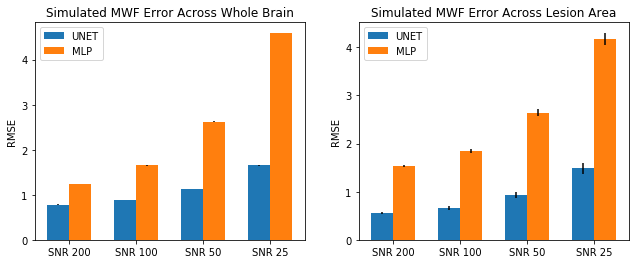

In [83]:
WHOLE_BRAIN_UNET200 = 0
WHOLE_BRAIN_UNET100 = 0.15
WHOLE_BRAIN_UNET50 = 0.3
WHOLE_BRAIN_UNET25 = 0.45

WHOLE_BRAIN_MLP200 = 0.05
WHOLE_BRAIN_MLP100 = 0.2
WHOLE_BRAIN_MLP50 = 0.35
WHOLE_BRAIN_MLP25 = 0.5

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(right=1.5)

axs[0].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50, WHOLE_BRAIN_UNET25], 
           [statistics['res256snr200Avg']['unet'][0][0][0],statistics['res256snr100Avg']['unet'][0][0][0],
            statistics['res256snr50Avg']['unet'][0][0][0], statistics['res256snr25Avg']['unet'][0][0][0]], 
           yerr=[statistics['res256snr200Avg']['unet'][1][0][0],statistics['res256snr100Avg']['unet'][1][0][0],
            statistics['res256snr50Avg']['unet'][1][0][0], statistics['res256snr25Avg']['unet'][1][0][0]],
           width=0.05, label = "UNET")

axs[0].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50, WHOLE_BRAIN_MLP25], 
           [statistics['res256snr200Avg']['mlp'][0][0][0],statistics['res256snr100Avg']['mlp'][0][0][0],
            statistics['res256snr50Avg']['mlp'][0][0][0], statistics['res256snr25Avg']['mlp'][0][0][0]], 
           yerr=[statistics['res256snr200Avg']['mlp'][1][0][0],statistics['res256snr100Avg']['mlp'][1][0][0],
            statistics['res256snr50Avg']['mlp'][1][0][0], statistics['res256snr25Avg']['mlp'][1][0][0]], 
           width=0.05, label = "MLP")

axs[0].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2, (WHOLE_BRAIN_UNET25+WHOLE_BRAIN_MLP25)/2])
axs[0].set_xticklabels(["SNR 200", "SNR 100", "SNR 50", "SNR 25"])
axs[0].set_ylabel("RMSE")
axs[0].set_title("Simulated MWF Error Across Whole Brain")
axs[0].legend(loc = "upper left")

axs[1].bar([WHOLE_BRAIN_UNET200, WHOLE_BRAIN_UNET100, WHOLE_BRAIN_UNET50, WHOLE_BRAIN_UNET25], 
           [statistics['res256snr200LesionAvg']['unet'][0][0][0],statistics['res256snr100LesionAvg']['unet'][0][0][0],
            statistics['res256snr50LesionAvg']['unet'][0][0][0], statistics['res256snr25LesionAvg']['unet'][0][0][0]], 
           yerr=[statistics['res256snr200LesionAvg']['unet'][1][0][0],statistics['res256snr100LesionAvg']['unet'][1][0][0],
            statistics['res256snr50LesionAvg']['unet'][1][0][0], statistics['res256snr25LesionAvg']['unet'][1][0][0]],
           width=0.05, label = "UNET")

axs[1].bar([WHOLE_BRAIN_MLP200, WHOLE_BRAIN_MLP100, WHOLE_BRAIN_MLP50, WHOLE_BRAIN_MLP25], 
           [statistics['res256snr200LesionAvg']['mlp'][0][0][0],statistics['res256snr100LesionAvg']['mlp'][0][0][0],
            statistics['res256snr50LesionAvg']['mlp'][0][0][0], statistics['res256snr25LesionAvg']['mlp'][0][0][0]], 
           yerr=[statistics['res256snr200LesionAvg']['mlp'][1][0][0],statistics['res256snr100LesionAvg']['mlp'][1][0][0],
            statistics['res256snr50LesionAvg']['mlp'][1][0][0], statistics['res256snr25LesionAvg']['mlp'][1][0][0]],
           width=0.05, label = "MLP")

axs[1].set_xticks([(WHOLE_BRAIN_UNET200+WHOLE_BRAIN_MLP200)/2, (WHOLE_BRAIN_UNET100+WHOLE_BRAIN_MLP100)/2, 
                   (WHOLE_BRAIN_UNET50+WHOLE_BRAIN_MLP50)/2, (WHOLE_BRAIN_UNET25+WHOLE_BRAIN_MLP25)/2])
axs[1].set_xticklabels(["SNR 200", "SNR 100", "SNR 50", "SNR 25"])
axs[1].set_ylabel("RMSE")
axs[1].set_title("Simulated MWF Error Across Lesion Area")
axs[1].legend(loc = "upper left")

plt.show()

In [84]:
case = '2245'
FLAIR_PATH = {"2245": "2245_20191012_161000_T2FLAIR_to_FASTT2.nii.gz"}

image_u_25 = nib.load(f'results/0_weight/MWF/{case}_pred_UNET_256sim_snr25.nii.gz').get_fdata()
image_u_50 = nib.load(f'results/0_weight/MWF/{case}_pred_UNET_256sim_snr50.nii.gz').get_fdata()
image_u_100 = nib.load(f'results/0_weight/MWF/{case}_pred_UNET_256sim_snr100.nii.gz').get_fdata()
image_u_200 = nib.load(f'results/0_weight/MWF/{case}_pred_UNET_256sim_snr200.nii.gz').get_fdata()
err_u_25 = nib.load(f'results/0_weight/MWF/{case}_err_UNET_256sim_snr25.nii.gz').get_fdata()
err_u_50 = nib.load(f'results/0_weight/MWF/{case}_err_UNET_256sim_snr50.nii.gz').get_fdata()
err_u_100 = nib.load(f'results/0_weight/MWF/{case}_err_UNET_256sim_snr100.nii.gz').get_fdata()
err_u_200 = nib.load(f'results/0_weight/MWF/{case}_err_UNET_256sim_snr200.nii.gz').get_fdata()

image_a_25 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_pred_MLP_256sim_snr25.nii.gz').get_fdata()
image_a_50 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_pred_MLP_256sim_snr50.nii.gz').get_fdata()
image_a_100 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_pred_MLP_256sim_snr100.nii.gz').get_fdata()
image_a_200 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_pred_MLP_256sim_snr200.nii.gz').get_fdata()
err_a_25 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_err_MLP_256sim_snr25.nii.gz').get_fdata()
err_a_50 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_err_MLP_256sim_snr50.nii.gz').get_fdata()
err_a_100 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_err_MLP_256sim_snr100.nii.gz').get_fdata()
err_a_200 = nib.load(f'results/ann_gpu3_256_32/MWF/{case}_err_MLP_256sim_snr200.nii.gz').get_fdata()

label = nib.load(f"results/0_weight/MWF/{case}_label_UNET_256real.nii.gz").get_fdata()
FLAIR = nib.load(f"../{case}/{FLAIR_PATH[case]}").get_fdata()
brain_mask = nib.load(f"../{case}/cropped_mask.nii.gz").get_fdata()
crop = nib.load("2245_crop.nii.gz").get_fdata()
brain_mask[crop == 1] = 0

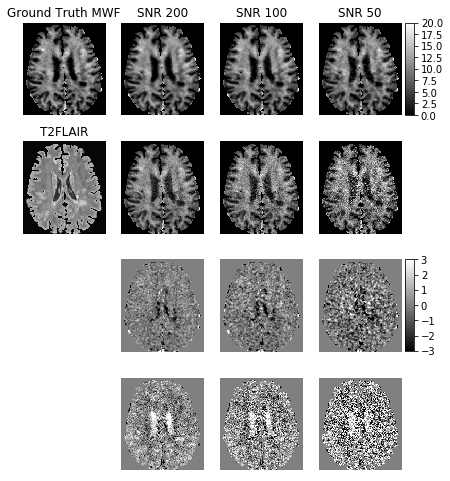

In [87]:
fig, axs = plt.subplots(4,4)
SLICE = 19
arr = [[label, image_u_200, image_u_100, image_u_50],
       [FLAIR, image_a_200, image_a_100, image_a_50],
       [None, err_u_200, err_u_100, err_u_50],
       [None, err_a_200, err_a_100, err_a_50]]
clips = [[[0,20], [0,20], [0,20], [0,20], [0,20]], 
         [[], [0,20], [0,20], [0,20], [0,20]], 
         [[], [-3,3], [-3,3], [-3,3], [-3,3]],
         [[], [-3,3], [-3,3], [-3,3], [-3,3]]]
titles = [[ "Ground Truth MWF", "SNR 200", "SNR 100", "SNR 50"],
        ["T2FLAIR", "SNR 200", "SNR 100", "SNR 50"],
          ["", "SNR 200", "SNR 100", "SNR 50"],
          ["", "SNR 200", "SNR 100", "SNR 50"]]
pos = [[1.01,1.369,0.02,0.32], None, [1.01,0.55,0.02,0.318]]
fig.subplots_adjust(right=1.0,top=1.7)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        if (j == 0 and (i == 2 or i == 3)):
            axs[i][j].set_visible(False)
            continue
        sliced = (slice(50,-50),slice(40,-40),SLICE)
        image = arr[i][j][sliced]
        im = ""
        display = image * brain_mask[sliced]
        display = np.rot90(display)
        if (len(clips[i][j]) == 2):
            im = axs[i][j].imshow(display, cmap="gray", vmin=clips[i][j][0], vmax=clips[i][j][1])
        else:
            im = axs[i][j].imshow(display, cmap="gray")
        if (i == 0 or j == 0):
            axs[i][j].set_title(titles[i][j])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].axis('off')
        if (j == 3 and (i == 2 or i == 0)):
            cb = fig.add_axes(pos[i])
            cb = fig.colorbar(im, cax=cb)
            if (i > 0):
                cb.set_ticks([3,2,1,0,-1,-2,-3])

In [88]:
dfs = [wholeBrainErr, lesionErr, reproDataNLLS, reproDataUNET, reproDataMLP, 
errsReproBrains, simulationErrorsWholeBrainSNR200, 
simulationErrorsWholeBrainSNR100, simulationErrorsWholeBrainSNR50, simulationErrorsWholeBrainSNR25, 
simulationErrorsLesionSNR200, simulationErrorsLesionSNR100, simulationErrorsLesionSNR50, 
simulationErrorsLesionSNR25]

df_names = ["wholeBrainErr_Fig2.csv", "lesionErr_Fig2.csv", "reproDataNLLS_Fig4.csv", "reproDataUNET_Fig4.csv", 
            "reproDataMLP_Fig4.csv", "errsReproBrains_Fig5.csv", "simulationErrorsWholeBrainSNR200_Fig6.csv", 
            "simulationErrorsWholeBrainSNR100_Fig6.csv", "simulationErrorsWholeBrainSNR50_Fig6.csv", 
            "simulationErrorsWholeBrainSNR25_Fig6.csv", 
            "simulationErrorsLesionSNR200_Fig6.csv", "simulationErrorsLesionSNR100_Fig6.csv", 
            "simulationErrorsLesionSNR50_Fig6.csv", "simulationErrorsLesionSNR25_Fig6.csv"]

for idx in range(len(dfs)):
    dfs[idx].to_csv(df_names[idx])

## Data Validity Test

### Figure 2

In [92]:
data = pd.read_csv(df_names[0])
data.head()

,Unnamed: 0,id,unet_myelin,unet_iewf,unet_csff,unet_myelinT2,unet_iewfT2,unet_csffT2,mlp_myelin,mlp_iewf,mlp_csff,mlp_myelinT2,mlp_iewfT2,mlp_csffT2
0,0,1684,0.595622,1.229036,1.078343,1.027194,1.263634,0.015830,1.167220,1.068256,0.366823,1.678888,1.371807,0.014898
1,1,1686,1.196950,2.178798,1.250020,1.271209,2.198553,0.015310,1.067626,0.981385,0.375411,1.721172,1.251045,0.012749
2,2,1710,1.037987,1.397922,0.894048,1.017281,1.778463,0.013296,1.395497,1.290828,0.373134,1.589741,1.499378,0.016582
3,3,1720,0.556995,1.252037,1.052532,1.036094,1.050193,0.010780,1.102682,1.000563,0.311340,1.428877,1.139444,0.010785
4,4,1739,0.660561,1.403395,1.117937,1.086135,1.342067,0.016169,1.137476,1.047376,0.375384,1.671019,1.283972,0.014163


In [94]:
data2 = pd.read_csv(df_names[1])
data2.head()

,Unnamed: 0,id,unet_myelin,unet_iewf,unet_csff,unet_myelinT2,unet_iewfT2,unet_csffT2,mlp_myelin,mlp_iewf,mlp_csff,mlp_myelinT2,mlp_iewfT2,mlp_csffT2
0,0,1684,0.581553,1.090137,0.707624,1.305856,3.505441,0.008458,1.227638,1.039880,0.438203,2.450253,1.880504,0.007432
1,1,1686,1.364453,2.763652,1.431906,1.831551,2.010029,0.009064,1.197371,0.869553,0.528962,2.503697,2.216540,0.010248
2,2,1710,1.331063,1.248416,0.744192,1.186946,2.549295,0.010603,1.313139,1.175723,0.577373,1.817193,2.585354,0.010108
3,3,1720,0.560671,0.999257,0.938942,0.976040,1.927999,0.013744,1.195888,1.061902,0.336682,1.690761,1.899477,0.009001
4,4,1739,0.595780,1.566916,1.331639,1.062343,1.918039,0.013215,1.194317,0.977522,0.444863,2.004465,2.215759,0.009672


In [95]:
unetWholeData = data["unet_myelin"]
unetLesionData = data2["unet_myelin"]
mlpWholeData = data["mlp_myelin"]
mlpLesionData = data2["mlp_myelin"]

In [98]:
print(np.mean(unetWholeData), np.std(unetWholeData))
print(np.mean(mlpWholeData), np.std(mlpWholeData))
print(np.mean(unetLesionData), np.std(unetLesionData))
print(np.mean(mlpLesionData), np.std(mlpLesionData))

0.7261852746776315 0.25554731522405366
1.1811577600320426 0.11737701929471261
0.742977548145684 0.38482984009630455
1.2329819524632541 0.3065846647232498


In [97]:
print(np.mean(statistics["res256"]['unet'][0]), np.std(statistics["res256"]['unet'][0]))
print(np.mean(statistics["res256"]['mlp'][0]), np.std(statistics["res256"]['mlp'][0]))
print(np.mean(statistics["res256Lesion"]['unet'][0]), np.std(statistics["res256Lesion"]['unet'][0]))
print(np.mean(statistics["res256Lesion"]['mlp'][0]), np.std(statistics["res256Lesion"]['mlp'][0]))

0.7261852746776314 0.25554731522405366
1.1811577600320426 0.11737701929471263
0.742977548145684 0.3848298400963046
1.2329819524632541 0.30658466472324986


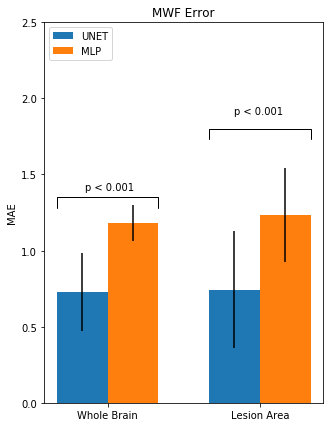

In [96]:
WHOLE_BRAIN_UNET = -0.1
WHOLE_BRAIN_MLP = -0.05
LESION_UNET = 0.05
LESION_MLP = 0.1
x = [WHOLE_BRAIN_UNET, LESION_UNET]
arrowprops = {"arrowstyle": "-", "shrinkA": 20, "shrinkB": 20, "connectionstyle": "bar"}
plt.figure(figsize=(5,7))
plt.bar(x, [np.mean(unetWholeData), np.mean(unetLesionData)], 
        width = 0.05, yerr = [np.std(unetWholeData), 
                              np.std(unetLesionData)], label="UNET")
x = [WHOLE_BRAIN_MLP, LESION_MLP]
plt.bar(x, [np.mean(mlpWholeData), np.mean(mlpLesionData)], 
        width = 0.05, yerr = [np.std(mlpWholeData),
                              np.std(mlpLesionData)], label="MLP")
plt.xticks([-0.075, 0.075], ["Whole Brain", "Lesion Area"])
plt.annotate("p < 0.001", xy=(-0.097,1.4))
plt.annotate("", xy=(-0.125,1.15),xytext=(-0.025,1.15), arrowprops=arrowprops)
plt.annotate("p < 0.001", xy=(0.05,1.9))
plt.annotate("", xy=(0.025,1.6),xytext=(0.125,1.6), arrowprops=arrowprops)
plt.ylabel("MAE")
plt.title("MWF Error")
plt.legend(loc = "upper left")
plt.ylim(0,2.5)
plt.show()

### Figure 4

In [105]:
nlls_data = pd.read_csv("reproDataNLLS_Fig4.csv")
unet_data = pd.read_csv("reproDataUNET_Fig4.csv")
mlp_data = pd.read_csv("reproDataMLP_Fig4.csv")
nlls_data.head()

,Unnamed: 0,id,scanv1,scanv2
0,0,"184051-3201,4201-wm_frontal_lobe",10.781975,11.072784
1,1,"184051-3206,4206-wm_parietal_lobe",9.480332,9.628179
2,2,"184051-3205,4205-wm_temporal_lobe",8.724325,8.729078
3,3,"184051-3204,4204-wm_occipital_lobe",8.367299,8.604857
4,4,"184051-10,49-thalamus",5.580222,5.688427


/usr/lib/python3/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


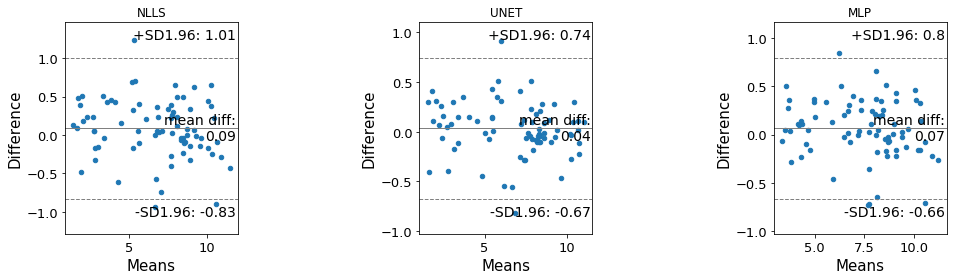

In [102]:
fig, axs = plt.subplots(1,3)
data = [[nlls_data['scanv1'], nlls_data['scanv2']], 
        [unet_data['scanv1'], unet_data['scanv2']], 
        [mlp_data['scanv1'], mlp_data['scanv2']]]
titles = ["NLLS", "UNET", "MLP"]
for idx in range(len(axs)):
    ax = axs[idx]
    ax.set_title(titles[idx])
    values = value_list[idx]
    data1 = np.array(data[idx][0])
    data2 = np.array(data[idx][1])
    mean_diff_plot(data1, data2, ax = ax)
fig.subplots_adjust(right=2.2)
fig.show()

### Figure 5

In [106]:
data = pd.read_csv("errsReproBrains_Fig5.csv")
data.head()

,Unnamed: 0,id,unet,mlp
0,0,125545,0.478345,1.022396
1,1,93924,0.902852,1.084038
2,2,151026,0.526380,1.063201
3,3,111721,0.954057,1.225200
4,4,93923,0.833057,1.115660


In [107]:
unetData = data['unet']
mlpData = data['mlp']

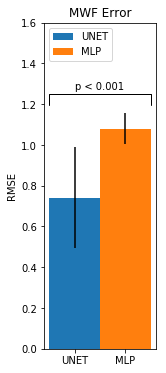

In [108]:
WHOLE_BRAIN_UNET = -0.025
WHOLE_BRAIN_MLP = 0.025
x = [WHOLE_BRAIN_UNET]
arrowprops = {"arrowstyle": "-", "shrinkA": 20, "shrinkB": 20, "connectionstyle": "bar"}
plt.figure(figsize=(2,6))
plt.bar(x, [np.mean(unetData)], width = 0.05, 
        yerr = [np.std(unetData)], label="UNET")
x = [WHOLE_BRAIN_MLP]
plt.bar(x, [np.mean(mlpData)], 
        width = 0.05, yerr = [np.std(mlpData)], label="MLP")
plt.xticks([WHOLE_BRAIN_UNET, WHOLE_BRAIN_MLP], ["UNET", "MLP"])
plt.annotate("p < 0.001", xy=(-0.025,1.27))
plt.annotate("", xy=(-0.05,1.1),xytext=(0.05,1.1), arrowprops=arrowprops)
plt.ylabel("RMSE")
plt.ylim(0,1.6)
plt.title("MWF Error")
plt.legend(loc = "upper left")
plt.show()

In [111]:
print(np.mean(unetData), np.std(unetData))
print(np.mean(mlpData), np.std(mlpData))

0.7417864238918778 0.24830290046787087
1.0798673476578728 0.07717870579666082


In [110]:
print(np.mean(statistics["resRepro"]['unet'][0]), np.std(statistics["resRepro"]['unet'][0]))
print(np.mean(statistics["resRepro"]['mlp'][0]), np.std(statistics["resRepro"]['mlp'][0]))

0.7417864238918779 0.24830290046787085
1.0798673476578726 0.07717870579666081


### Figure 6

In [113]:
data_urls = ["simulationErrorsWholeBrainSNR200_Fig6.csv", 
             "simulationErrorsWholeBrainSNR100_Fig6.csv", "simulationErrorsWholeBrainSNR50_Fig6.csv", 
             "simulationErrorsWholeBrainSNR25_Fig6.csv", 
             "simulationErrorsLesionSNR200_Fig6.csv", "simulationErrorsLesionSNR100_Fig6.csv", 
             "simulationErrorsLesionSNR50_Fig6.csv", "simulationErrorsLesionSNR25_Fig6.csv"]
data = []
for url in data_urls:
    data.append(pd.read_csv(url))
data[0].head()

,Unnamed: 0,id,unet,mlp
0,0,2245,0.783027,1.233295
1,1,2245,0.785479,1.233597
2,2,2245,0.783625,1.235084
3,3,2245,0.780332,1.232838
4,4,2245,0.780500,1.233598


In [120]:
print(np.mean(data[0]['unet']), np.std(data[0]['unet']))
print(statistics['res256snr200Avg']['unet'][0][0], statistics['res256snr200Avg']['unet'][1][0])
print("=====")
print(np.mean(data[1]['unet']), np.std(data[1]['unet']))
print(statistics['res256snr100Avg']['unet'][0][0], statistics['res256snr100Avg']['unet'][1][0])
print("=====")
print(np.mean(data[2]['unet']), np.std(data[2]['unet']))
print(statistics['res256snr50Avg']['unet'][0][0], statistics['res256snr50Avg']['unet'][1][0])
print("=====")
print(np.mean(data[3]['unet']), np.std(data[3]['unet']))
print(statistics['res256snr25Avg']['unet'][0][0], statistics['res256snr25Avg']['unet'][1][0])

0.7835615896323705 0.0012405918767032424
[0.78356159] [0.00124059]
=====
0.8818547963243724 0.0023117613586772575
[0.8818548] [0.00231176]
=====
1.1331377538713743 0.003959603336932714
[1.13313775] [0.0039596]
=====
1.6534265831247354 0.006259242560993597
[1.65342658] [0.00625924]


In [123]:
print(np.mean(data[0]['mlp']), np.std(data[0]['mlp']))
print(statistics['res256snr200Avg']['mlp'][0][0], statistics['res256snr200Avg']['mlp'][1][0])
print("=====")
print(np.mean(data[1]['mlp']), np.std(data[1]['mlp']))
print(statistics['res256snr100Avg']['mlp'][0][0], statistics['res256snr100Avg']['mlp'][1][0])
print("=====")
print(np.mean(data[2]['mlp']), np.std(data[2]['mlp']))
print(statistics['res256snr50Avg']['mlp'][0][0], statistics['res256snr50Avg']['mlp'][1][0])
print("=====")
print(np.mean(data[3]['mlp']), np.std(data[3]['mlp']))
print(statistics['res256snr25Avg']['mlp'][0][0], statistics['res256snr25Avg']['mlp'][1][0])

1.2333652606578656 0.0012033438952135489
[1.23336526] [0.00120334]
=====
1.6507858976723906 0.002205031607365374
[1.6507859] [0.00220503]
=====
2.626002026013396 0.0038132350711398443
[2.62600203] [0.00381324]
=====
4.589782644478492 0.007887017860859958
[4.58978264] [0.00788702]


In [125]:
print(np.mean(data[4]['unet']), np.std(data[4]['unet']))
print(statistics['res256snr200LesionAvg']['unet'][0][0], statistics['res256snr200LesionAvg']['unet'][1][0])
print("=====")
print(np.mean(data[5]['unet']), np.std(data[5]['unet']))
print(statistics['res256snr100LesionAvg']['unet'][0][0], statistics['res256snr100LesionAvg']['unet'][1][0])
print("=====")
print(np.mean(data[6]['unet']), np.std(data[6]['unet']))
print(statistics['res256snr50LesionAvg']['unet'][0][0], statistics['res256snr50LesionAvg']['unet'][1][0])
print("=====")
print(np.mean(data[7]['unet']), np.std(data[7]['unet']))
print(statistics['res256snr25LesionAvg']['unet'][0][0], statistics['res256snr25LesionAvg']['unet'][1][0])

0.5562276099850375 0.019895463601465393
[0.55622761] [0.01989546]
=====
0.660026557481823 0.03303872308508998
[0.66002656] [0.03303872]
=====
0.9305243867275796 0.0561654651164539
[0.93052439] [0.05616547]
=====
1.4845118020595627 0.10743724016197512
[1.4845118] [0.10743724]


In [124]:
print(np.mean(data[4]['mlp']), np.std(data[4]['mlp']))
print(statistics['res256snr200LesionAvg']['mlp'][0][0], statistics['res256snr200LesionAvg']['mlp'][1][0])
print("=====")
print(np.mean(data[5]['mlp']), np.std(data[5]['mlp']))
print(statistics['res256snr100LesionAvg']['mlp'][0][0], statistics['res256snr100LesionAvg']['mlp'][1][0])
print("=====")
print(np.mean(data[6]['mlp']), np.std(data[6]['mlp']))
print(statistics['res256snr50LesionAvg']['mlp'][0][0], statistics['res256snr50LesionAvg']['mlp'][1][0])
print("=====")
print(np.mean(data[7]['mlp']), np.std(data[7]['mlp']))
print(statistics['res256snr25LesionAvg']['mlp'][0][0], statistics['res256snr25LesionAvg']['mlp'][1][0])

1.5338953659188506 0.02221418756873404
[1.53389537] [0.02221419]
=====
1.8474299501059284 0.03698549615870078
[1.84742995] [0.0369855]
=====
2.6409961167035263 0.06801859331403902
[2.64099612] [0.06801859]
=====
4.176691152618664 0.12542048706725803
[4.17669115] [0.12542049]
